In [8]:
import tensorflow as tf
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift
from alibi_detect.cd import KSDrift
import numpy as np
import methods
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode

import logging 
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [2]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
import torch
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [9]:
def test_ksd(cd, imgs_ref, imgs, label):
    p_vals = []
    distances = []
    labels = []
    imgs_array = []
    for img in imgs:
        p_val, dist = cd.feature_score(x_ref=imgs_ref, x=img.reshape(-1, 32, 32, 1))
        p_vals.append(np.mean(p_val))
        distances.append(np.mean(dist))
        labels.append(label)
        imgs_array.append(img)
    d = {"p_vals": p_vals, "distances": distances, "labels": labels, "imgs_array": imgs_array}

    df = pd.DataFrame(data=d)
    return df
def test_ksd_final(cd, imgs_ref, perturb = None, y_limit = None):
    inlier_scores = []
    inlier_labels = []
    outlier_scores = []
    outlier_labels = []
    inlier_path = "/home/erdem/dataset/urine_test_32/inliers"
    outlier_path = "/home/erdem/dataset/urine_test_32/outliers"
    # Inliers
    for img_path in Path(inlier_path).glob("*.png"):
        inlier_labels.append(0)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        _, dist = cd.feature_score(x_ref=imgs_ref, x=image.reshape(-1, 32, 32, 1))
        temp_score = np.amax(np.mean(dist))
        inlier_scores.append(temp_score)
    
    # Outliers
    for img_path in Path(outlier_path).glob("*.png"):
        outlier_labels.append(1)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        _, dist = cd.feature_score(x_ref=imgs_ref, x=image.reshape(-1, 32, 32, 1))
        temp_score = np.amax(np.mean(dist))
        outlier_scores.append(temp_score)
    
    d_outliers = {"K-S Distance": outlier_scores, "outlier_labels": outlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    d_inliers = {"K-S Distance": inlier_scores, "inlier_labels": inlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    df1 = pd.DataFrame(data=d_inliers)
    df2 = pd.DataFrame(data=d_outliers)
    g = sns.scatterplot(data=df1, x="Index of Image Patches", y="K-S Distance")
    g = sns.scatterplot(data=df2, x="Index of Image Patches", y="K-S Distance")
    g.set(ylim=(0, y_limit))
    score_array = inlier_scores+outlier_scores
    label_array = inlier_labels+outlier_labels

    print(calc_metrics(score_array, label_array))

    plot_roc(score_array, label_array)
    plot_pr(score_array, label_array)
#     plot_barcode(score_array, label_array)
    

In [10]:
# initialise drift detector
cd = KSDrift(X_inliers, p_val=.05, correction = 'fdr')

{'fpr_at_95_tpr': 0.3270440251572327, 'detection_error': 0.1878930817610063, 'auroc': 0.8922758197856098, 'aupr_out': 0.8748855158357249, 'aupr_in': 0.8922502776855072}


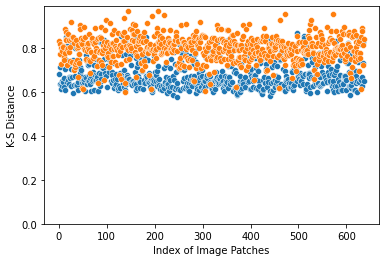

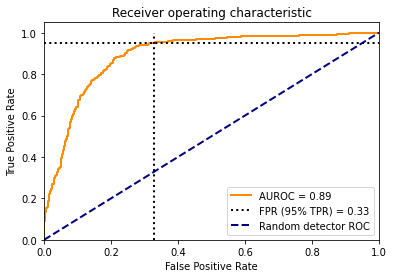

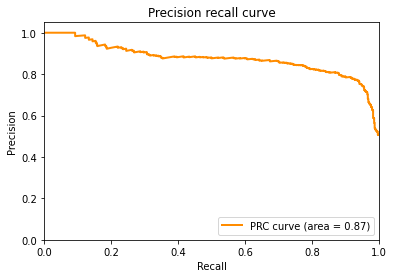

In [11]:
test_ksd_final(cd, X_inliers, perturb = None, y_limit = None)

<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

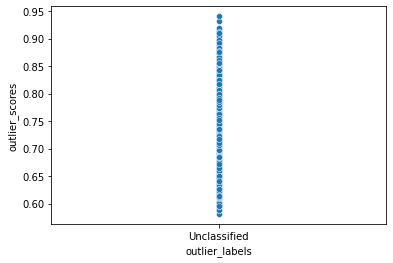

In [14]:
cl_path = "/home/thomas/tmp/patches_urine_32_scaled/Unclassified"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
cl = "Unclassified"  
for img_path in Path(cl_path).glob("*.png"):
    outlier_path.append(img_path)
    outlier_labels.append(cl)
    image = plt.imread(img_path)
    if perturb == 'gaussian':
        image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
    elif perturb == 's&p':
        image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
    _, dist = cd.feature_score(x_ref=X_inliers, x=image.reshape(-1, 32, 32, 1))
    temp_score = np.amax(np.mean(dist))
    outlier_scores.append(temp_score)
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df3 = pd.DataFrame(data=d)
sns.scatterplot(data=df3, x = "outlier_labels", y="outlier_scores")

In [15]:
sorted_unclassified = df3.sort_values(by=['outlier_scores'])

In [18]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [19]:
unclassified_imgs = []
for path in sorted_unclassified["outlier_path"]:
    unclassified_imgs.append(read_image(str(path)))

In [10]:
X_inliers.shape, testImages_LD.shape

((7965, 32, 32, 1), (12, 32, 32, 1))

In [13]:
x = X_inliers.reshape(X_inliers.shape[0], -1)
x_ref = testImages_LD[0].reshape(-1,32,32,1).reshape(testImages_LD.shape[0], -1)

ValueError: cannot reshape array of size 1024 into shape (12,newaxis)

In [12]:
print(x.shape)
print(x_ref.shape)

(7965, 1024)
(12, 1024)


In [8]:
sorted_p_vals = df_unclassified.sort_values(by=['p_vals'])
sorted_distaces = df_unclassified.sort_values(by=['distances'])

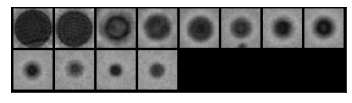

In [9]:
temp_imgs = []
for img in sorted_p_vals["imgs_array"]:
    temp_imgs.append(torch.from_numpy(img.reshape(1,32,32)))
grid = make_grid(temp_imgs)
show(grid)

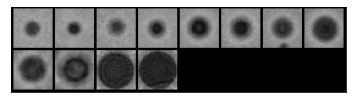

In [10]:
temp_imgs = []
for img in sorted_distaces["imgs_array"]:
    temp_imgs.append(torch.from_numpy(img.reshape(1,32,32)))
grid = make_grid(temp_imgs)
show(grid)

In [11]:
df_unclassified = test_ksd(cd, X_inliers, unclassified_imgs, 0)

In [12]:
sorted_p_vals = df_unclassified.sort_values(by=['p_vals'])

<AxesSubplot:xlabel='labels', ylabel='p_vals'>

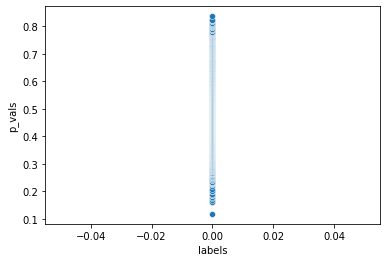

In [17]:
sns.scatterplot(data=sorted_p_vals, x = "labels", y="p_vals")

In [19]:
index = 0
# index: 717 and after is inlier
for a in sorted_p_vals['p_vals']:
    print(index, a)
    index += 1

0 0.11855357885360718
1 0.161111980676651
2 0.1624334305524826
3 0.16932013630867004
4 0.17656740546226501
5 0.18094581365585327
6 0.18607088923454285
7 0.18696469068527222
8 0.18736512959003448
9 0.19085097312927246
10 0.20136816799640656
11 0.20189586281776428
12 0.202926367521286
13 0.2030840516090393
14 0.20309753715991974
15 0.2074173390865326
16 0.2215820997953415
17 0.2263536900281906
18 0.2281630039215088
19 0.2286921739578247
20 0.22966259717941284
21 0.23112358152866364
22 0.23232269287109375
23 0.23285198211669922
24 0.23511198163032532
25 0.2354302704334259
26 0.2361374795436859
27 0.24008554220199585
28 0.24241456389427185
29 0.24460715055465698
30 0.2496054619550705
31 0.2496730238199234
32 0.2508811950683594
33 0.2514193058013916
34 0.25405287742614746
35 0.25537630915641785
36 0.25544190406799316
37 0.2611936330795288
38 0.26212936639785767
39 0.2622183561325073
40 0.26241612434387207
41 0.26272904872894287
42 0.2637461721897125
43 0.26476651430130005
44 0.2649073600769

1338 0.5423761010169983
1339 0.542944610118866
1340 0.543022871017456
1341 0.5430760383605957
1342 0.5431663990020752
1343 0.5438976287841797
1344 0.5443682670593262
1345 0.544464647769928
1346 0.5448020696640015
1347 0.5448175668716431
1348 0.5456143617630005
1349 0.5459778308868408
1350 0.5464470982551575
1351 0.5464528799057007
1352 0.5465548634529114
1353 0.5467255115509033
1354 0.5471873879432678
1355 0.5476292371749878
1356 0.5476745367050171
1357 0.5478612184524536
1358 0.5479358434677124
1359 0.5479727983474731
1360 0.5479797124862671
1361 0.5481669306755066
1362 0.5486676692962646
1363 0.5491277575492859
1364 0.5496861934661865
1365 0.5499590635299683
1366 0.5502758622169495
1367 0.5504007935523987
1368 0.5504145622253418
1369 0.550965428352356
1370 0.5511593818664551
1371 0.5514389276504517
1372 0.5516362190246582
1373 0.5517856478691101
1374 0.5523315668106079
1375 0.5525194406509399
1376 0.5525828003883362
1377 0.5526437759399414
1378 0.552727997303009
1379 0.55273818969726

In [26]:
# initialise drift detector
cd2 = KSDrift(X_inliers, p_val=.05, correction = 'bonferroni')

In [27]:
df_unclassified2 = test_ksd(cd2, X_inliers, unclassified_imgs, 0)

In [28]:
sorted_p_vals2 = df_unclassified2.sort_values(by=['p_vals'])

<AxesSubplot:xlabel='labels', ylabel='p_vals'>

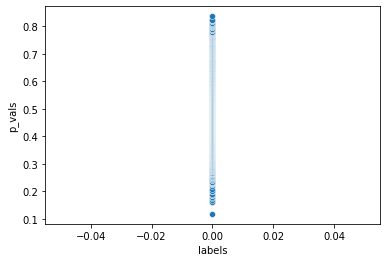

In [29]:
sns.scatterplot(data=sorted_p_vals2, x = "labels", y="p_vals")

In [ ]:
p_val, dist = cd.feature_score(x_ref=X_inliers, x=testImages_LD[0].reshape(-1, 32, 32, 1))

In [ ]:
print(np.mean(p_val))
print(np.mean(dist))

In [ ]:
for img in testImages_LD:
    p_val, dist = cd.feature_score(x_ref=X_inliers, x=img.reshape(-1, 32, 32, 1))
    print("p: ", np.mean(p_val))
    print("distance: ", np.mean(dist))
    plt.imshow(img, cmap='gray')
    plt.show()

In [ ]:
inliers_preds = cd.predict(X_inliers[0].reshape(-1,32,32,1), return_p_val = True, return_distance = True)
print(inliers_preds)

In [ ]:
inliers_preds = cd.predict(X_inliers[0].reshape(-1,32,32,1), return_p_val = True, return_distance = True)
print(inliers_preds)

In [ ]:
wbc_preds = cd.predict(testImages_WBC, return_p_val = True, return_distance = True)
print(wbc_preds)

In [ ]:
print(len(wbc_preds['data']['distance']))

In [ ]:
for data in wbc_preds['data']['distance']:
    print(data)

In [ ]:
wbc_preds = cd.predict(testImages_WBC, return_p_val = True, return_distance = True)
print(wbc_preds)

In [ ]:
rbc_preds = cd.predict(testImages_RBC, return_p_val = True, return_distance = True)
print(rbc_preds)

In [ ]:
for data in rbc_preds['data']['distance']:
    print(data)

In [ ]:
artifact_preds = cd.predict(testImages_Artifact, return_p_val = True, return_distance = True)
print(artifact_preds)

In [ ]:
for data in artifact_preds['data']['distance']:
    print(data)

In [ ]:
testImages_Dirt
dirt_preds = cd.predict(testImages_Dirt, return_p_val = True, return_distance = True)
print(dirt_preds)

In [ ]:
for data in dirt_preds['data']['distance']:
    print(data)

In [ ]:
print(len(dirt_preds['data']['distance']))